<a href="https://colab.research.google.com/github/saja13-zh/Arabic-Handwritten-Chars-DL/blob/main/deeplearning_project_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
from keras.metrics import CategoricalAccuracy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Function to read images from directory and extract labels
def read_images_from_directory(directory_path):
    image_data = []
    labels = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = cv2.imread(os.path.join(directory_path, filename))
            if img is not None:
                image_data.append(img)
                label = re.split(r'(\d+)', filename)[0]  # Assuming label is before a number
                labels.append(label)
    return image_data, labels

In [ ]:
# Load train and test data
train_data, train_labels = read_images_from_directory("/kaggle/input/arabic-chars-mnist/train")
test_data, test_labels = read_images_from_directory("/kaggle/input/arabic-chars-mnist/test")

# Convert lists to numpy arrays
train_data_np = np.array(train_data)
test_data_np = np.array(test_data)

# Normalize pixel values
train_data_np = train_data_np / 255.0
test_data_np = test_data_np / 255.0

In [ ]:
# Label encoding and one-hot encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

train_labels_onehot = to_categorical(train_labels_encoded, num_classes=28)
test_labels_onehot = to_categorical(test_labels_encoded, num_classes=28)

In [ ]:
# Model definition (original as per your structure with adjusted input shape)
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(28, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28)             │         7,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,588 (346.05 KB)

 Trainable params: 88,588 (346.05 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor the validation loss
    min_delta=0.001,        # Minimum change to qualify as an improvement
    patience=5,             # Stop after 5 epochs without improvement
    verbose=1,              # Print progress
    mode='auto',            # Automatically determine the direction of improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)

**Batch size 32 and Epochs 10**

In [ ]:
# Train the model
history = model.fit(
    train_data_np,
    train_labels_onehot,
    validation_data=(test_data_np, test_labels_onehot),
    batch_size=32,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9264 - loss: 0.2141 - precision: 0.9380 - recall: 0.9158 - val_accuracy: 0.9176 - val_loss: 0.2546 - val_precision: 0.9267 - val_recall: 0.9074
Epoch 2/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9320 - loss: 0.1889 - precision: 0.9409 - recall: 0.9230 - val_accuracy: 0.9256 - val_loss: 0.2299 - val_precision: 0.9337 - val_recall: 0.9185
Epoch 3/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9449 - loss: 0.1707 - precision: 0.9533 - recall: 0.9358 - val_accuracy: 0.9277 - val_loss: 0.2270 - val_precision: 0.9373 - val_recall: 0.9202
Epoch 4/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9418 - loss: 0.1680 - precision: 0.9494 - recall: 0.9341 - val_accuracy: 0.9280 - val_loss: 0.2131 - val_precision: 0.9355 - val_recall: 0.9193
Epoch 5/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9466 - loss: 0.1518 - precision: 0.9542 - recall: 0.9411 - val_accuracy: 0.9396 - va

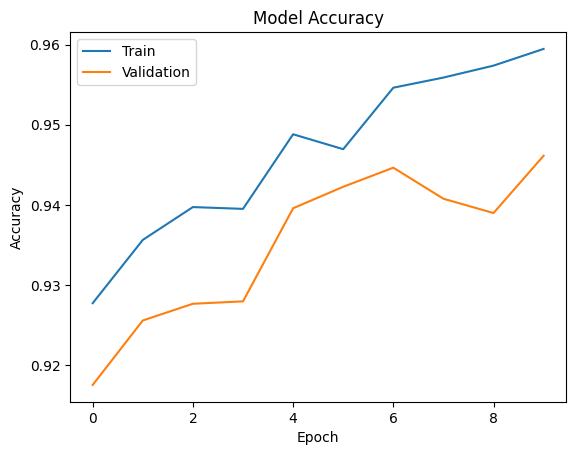

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data_np, test_labels_onehot, verbose=0)

In [ ]:
# Use the model to make predictions
test_predictions = model.predict(test_data_np)
test_predictions = np.argmax(test_predictions, axis=1)
test_true_labels = np.argmax(test_labels_onehot, axis=1)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [ ]:
# Calculate detailed classification report
class_report = classification_report(test_true_labels, test_predictions)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95       120
           1       1.00      0.99      1.00       120
           2       0.92      0.99      0.96       120
           3       0.98      0.89      0.93       120
           4       0.85      0.98      0.91       120
           5       0.85      0.93      0.89       120
           6       0.99      0.97      0.98       120
           7       0.95      0.94      0.95       120
           8       0.97      0.94      0.96       120
           9       0.91      0.97      0.94       120
          10       0.97      0.97      0.97       120
          11       0.95      0.97      0.96       120
          12       0.99      0.99      0.99       120
          13       0.98      1.00      0.99       120
          14       0.93      0.93      0.93       120
          15       0.92      0.91      0.92       120
          16       0.94      0.89      0.91       120
   

In [ ]:
# Print the metrics
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Test Loss: 0.17977288365364075
Test Accuracy: 0.9461309313774109
Test Precision: 0.9504801630973816
Test Recall: 0.942559540271759


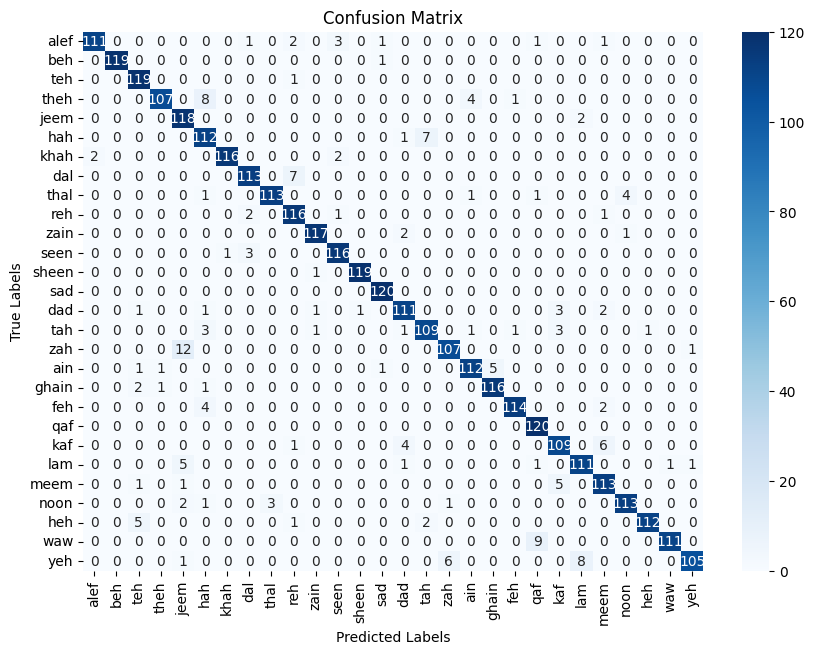

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(test_true_labels, test_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain',
                'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh'], yticklabels=['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain',
                'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Batch size 32 and Epochs 50**

In [ ]:
# Train the model
history = model.fit(
    train_data_np,
    train_labels_onehot,
    validation_data=(test_data_np, test_labels_onehot),
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9659 - loss: 0.0989 - precision: 0.9689 - recall: 0.9628 - val_accuracy: 0.9405 - val_loss: 0.1984 - val_precision: 0.9463 - val_recall: 0.9387
Epoch 2/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9642 - loss: 0.1004 - precision: 0.9671 - recall: 0.9606 - val_accuracy: 0.9405 - val_loss: 0.2025 - val_precision: 0.9457 - val_recall: 0.9378
Epoch 3/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9655 - loss: 0.0950 - precision: 0.9690 - recall: 0.9624 - val_accuracy: 0.9429 - val_loss: 0.1924 - val_precision: 0.9479 - val_recall: 0.9414
Epoch 4/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9679 - loss: 0.0889 - precision: 0.9707 - recall: 0.9654 - val_accuracy: 0.9491 - val_loss: 0.1819 - val_precision: 0.9515 - val_recall: 0.9467
Epoch 5/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9679 - loss: 0.0880 - precision: 0.9710 - recall: 0.9655 - val_accuracy: 0.9414 - va

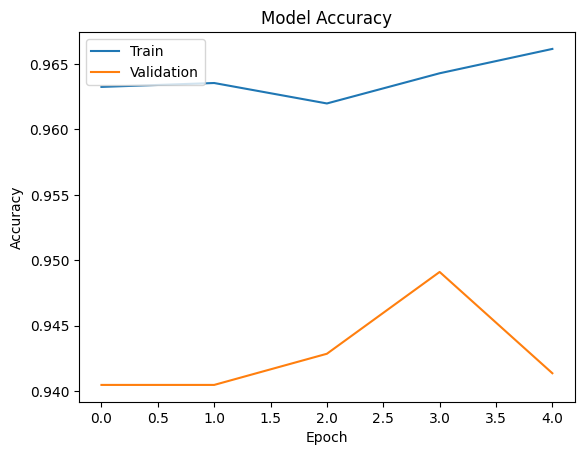

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data_np, test_labels_onehot, verbose=0)

In [ ]:
# Use the model to make predictions
test_predictions = model.predict(test_data_np)
test_predictions = np.argmax(test_predictions, axis=1)
test_true_labels = np.argmax(test_labels_onehot, axis=1)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [ ]:
# Calculate detailed classification report
class_report = classification_report(test_true_labels, test_predictions)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       120
           1       0.97      0.99      0.98       120
           2       0.97      0.97      0.97       120
           3       0.93      0.90      0.92       120
           4       0.97      0.93      0.95       120
           5       0.88      0.92      0.90       120
           6       0.92      0.99      0.96       120
           7       0.95      0.97      0.96       120
           8       0.96      0.96      0.96       120
           9       1.00      0.94      0.97       120
          10       0.99      0.94      0.97       120
          11       0.95      0.95      0.95       120
          12       0.98      0.99      0.98       120
          13       0.95      0.99      0.97       120
          14       0.95      0.88      0.91       120
          15       0.95      0.88      0.91       120
          16       0.94      0.94      0.94       120
   

In [ ]:
# Print the metrics
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Test Loss: 0.19841445982456207
Test Accuracy: 0.9404761791229248
Test Precision: 0.9462946057319641
Test Recall: 0.9386904835700989


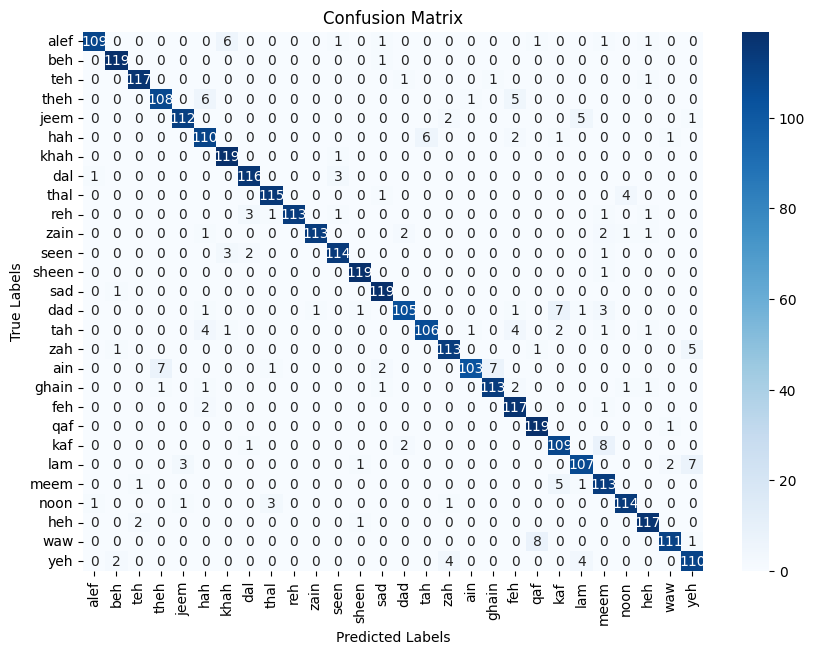

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(test_true_labels, test_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain',
                'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh'], yticklabels=['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain',
                'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Batch size 64 Epoch 10**

In [ ]:
# Train the model
history = model.fit(
    train_data_np,
    train_labels_onehot,
    validation_data=(test_data_np, test_labels_onehot),
    batch_size=64,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9744 - loss: 0.0777 - precision: 0.9776 - recall: 0.9720 - val_accuracy: 0.9542 - val_loss: 0.1762 - val_precision: 0.9561 - val_recall: 0.9524
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9783 - loss: 0.0659 - precision: 0.9796 - recall: 0.9770 - val_accuracy: 0.9586 - val_loss: 0.1588 - val_precision: 0.9614 - val_recall: 0.9563
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9816 - loss: 0.0552 - precision: 0.9824 - recall: 0.9809 - val_accuracy: 0.9527 - val_loss: 0.1723 - val_precision: 0.9549 - val_recall: 0.9509
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9815 - loss: 0.0553 - precision: 0.9831 - recall: 0.9808 - val_accuracy: 0.9551 - val_loss: 0.1700 - val_precision: 0.9578 - val_recall: 0.9521
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9804 - loss: 0.0606 - precision: 0.9814 - recall: 0.9786 - val_accuracy: 0.9563 - val_l

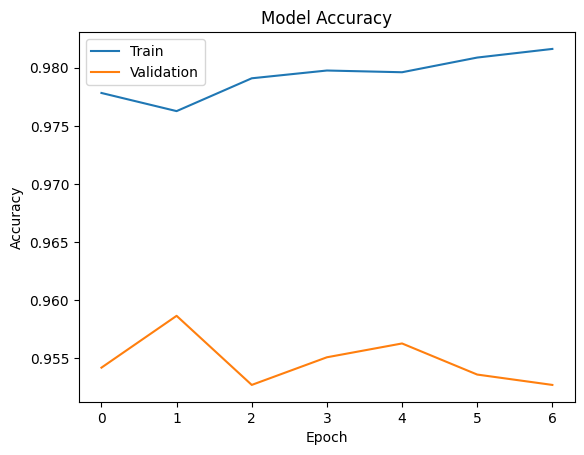

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data_np, test_labels_onehot, verbose=0)

In [ ]:
# Use the model to make predictions
test_predictions = model.predict(test_data_np)
test_predictions = np.argmax(test_predictions, axis=1)
test_true_labels = np.argmax(test_labels_onehot, axis=1)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [ ]:
# Calculate detailed classification report
class_report = classification_report(test_true_labels, test_predictions)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       120
           1       1.00      1.00      1.00       120
           2       0.98      0.98      0.98       120
           3       1.00      0.93      0.97       120
           4       0.97      0.93      0.94       120
           5       0.93      0.96      0.94       120
           6       0.97      0.97      0.97       120
           7       0.91      0.98      0.95       120
           8       0.97      0.97      0.97       120
           9       0.98      0.94      0.96       120
          10       0.98      0.97      0.97       120
          11       0.98      0.93      0.96       120
          12       0.98      1.00      0.99       120
          13       0.99      1.00      1.00       120
          14       0.92      0.93      0.92       120
          15       0.96      0.92      0.94       120
          16       0.93      0.97      0.95       120
   

In [ ]:
# Print the metrics
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Test Loss: 0.15878687798976898
Test Accuracy: 0.9586309790611267
Test Precision: 0.9614003300666809
Test Recall: 0.956250011920929


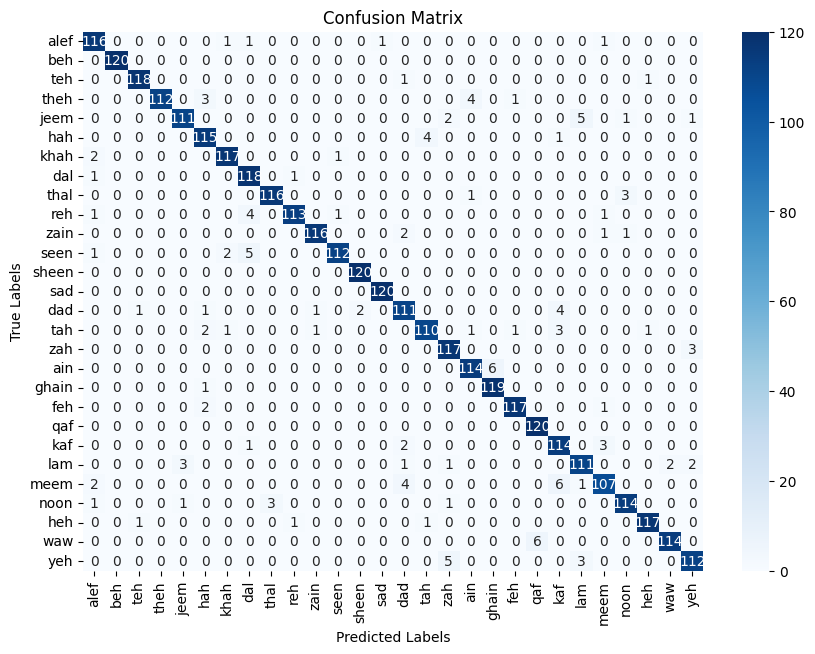

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(test_true_labels, test_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain',
                'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh'], yticklabels=['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain',
                'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()